In this notebook the argon reanalysis is repeated as a test for my megatrees. The analysis needs to yield the same as with Kevins minitrees. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mtpl
import shutil
import awkward as ak
import sys,os

import uproot4 
from matplotlib.colors import LogNorm
sys.path.append("/home/uzh/sbuse/1_MT/experimental_rate/argon_reanalysis/helpers")
from square_plotting import colorbar


In [2]:
import ROOT

Welcome to JupyROOT 6.14/00


In [3]:
folder_names = ["0.248kV","0.31kV","0.62kV","1.24kV","1.86kV","2.48kV","3.00kV_longterm","3.10kV","3.00kV"]
processed_data_path = "/disk/bulk_atp/thiemek/XurichII/processed/Run3/"
minitree_data_path = "/disk/bulk_atp/thiemek/XurichII/minitrees/Run3/"
saving_path= "/disk/data8/student/sbuse/megatrees/3.00kV/"

# Let's load more files

## Iterate through them.

In [4]:
saving_path= "/disk/data8/student/sbuse/megatrees_without_splitting/"
complete_megatrees = []

for entry in os.scandir(saving_path+"3.00kV/"):
    if (entry.path.startswith(saving_path+"3.00kV/megatree_complete_")):
        complete_megatrees.append(entry.path+":t1")

complete_megatrees.sort()
complete_megatrees = complete_megatrees[:10]
len(complete_megatrees)

10

In [5]:
%load_ext autoreload
%autoreload 2
from argon_kshell_cuts_3kV import argon_kshell_cuts_3kV 

events = ak.Array([])
for batch in uproot4.iterate(complete_megatrees,how="zip"):
    cut_batch = argon_kshell_cuts_3kV(batch)
    if ak.num(cut_batch,axis=0)!=0:
        events = ak.concatenate([events,cut_batch])
    
    
    
    
    

In [6]:
ak.type(events)

36650 * ?{"s2s_per_waveform": int32, "s1s_per_waveform": int32, "wave_number": int32, "unix_time": float64, "trigger_time_tag_uncorr": float64, "trigger_time_tag_corr": float64, "preceding_is_sat": bool, "npulses_pmt": int32, "s1": var * {"pos_bot": float64, "area_pe_top": float64, "area_pe_bot": float64, "width_bot": float64, "height_mvdc_bot": float64, "pulse_time": float64}, "s2": var * {"pos_bot": float64, "area_pe_top": float64, "area_pe_bot": float64, "width_bot": float64, "height_mvdc_bot": float64, "x_uncorr": float64, "y_uncorr": float64, "x_corr": float64, "y_corr": float64, "pulse_time": float64, "s2_frt": float64}, "mask_max_s1_before_s2": var * ?int64, "drifttime_musec": float64, "z": float64, "r_s2": float64}

## Number of S1 and S2 per event. Waveforms with no S2 were not processed. 

In [7]:
s2_nu = events["s2s_per_waveform"]
s1_nu = events["s1s_per_waveform"]

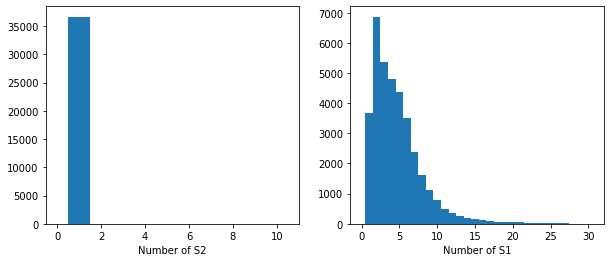

In [8]:
f, axes = plt.subplots(1, 2,figsize=(10,4))

axes[0].hist(np.array(s2_nu),range=[0,10],bins=np.concatenate([[0],np.linspace(0.5,10.5,11)]))
axes[0].set_xlabel("Number of S2")
axes[1].hist(np.array(s1_nu), bins=np.concatenate([[0],np.linspace(0.5,30.5,31)]))
axes[1].set_xlabel("Number of S1")
plt.show()

# Select the maximum S1 and S2

In [9]:
s2_area_pe_top = ak.flatten(events["s2","area_pe_top"])
s2_area_pe_bot = ak.flatten(events["s2","area_pe_bot"])
s1_area_pe_top = ak.flatten(events["s1","area_pe_top"][events["mask_max_s1_before_s2"]])
s1_area_pe_bot = ak.flatten(events["s1","area_pe_bot"][events["mask_max_s1_before_s2"]])

s2_area = s2_area_pe_top+s2_area_pe_bot
s1_area = s1_area_pe_top+s1_area_pe_bot

In [10]:
s1_area = np.array(s1_area)
s2_area = np.array(s2_area)

# Overview S1 vs S2

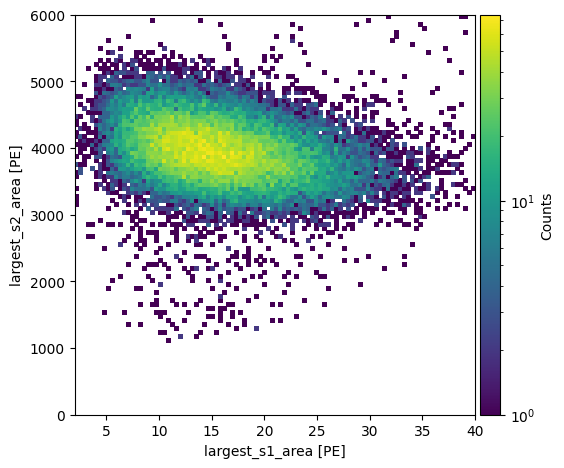

In [11]:


y_max_plot=5000
w, h = mtpl.figure.figaspect(0.94)
fig = plt.figure(figsize=(w, h), dpi=100)
axes = fig.add_axes([1,1,1,1])
h,xedges,yedges,img1 = axes.hist2d(s1_area,s2_area,range=[[2,40],[0,6000]],bins=(100,100),norm=LogNorm())
p=colorbar(img1)
p.set_label(r'Counts', rotation=90)
plt.xlabel('largest_s1_area [PE]')
plt.ylabel('largest_s2_area [PE]')
plt.show()

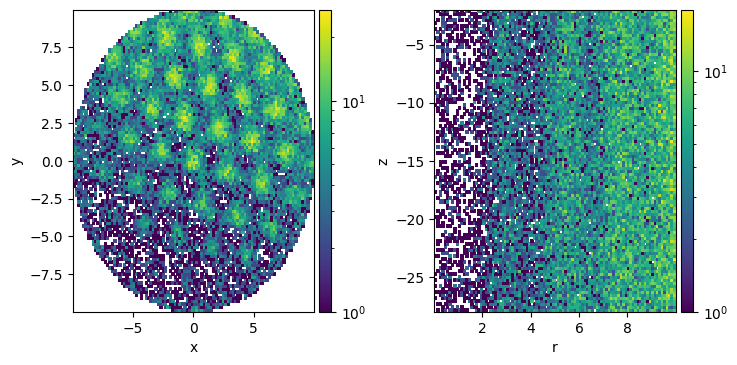

In [12]:
f, axes = plt.subplots(1, 2, figsize=(8, 4), dpi=100 )

_,_,_,img1 = axes[0].hist2d(np.array(ak.flatten(events.s2.x_corr)),np.array(ak.flatten(events.s2.y_corr)),
                        bins=(100,100),norm=LogNorm()) #range=[[2,40],[0,6000]]
p=colorbar(img1)
#p.set_label(r'Counts', rotation=90)
axes[0].set_xlabel('x')
axes[0].set_ylabel('y')


_,_,_,img1 = axes[1].hist2d(np.array(events["r_s2"]),np.array(events["z"]),
                        bins=(100,100),norm=LogNorm()) #range=[[2,40],[0,6000]]
p=colorbar(img1)
#p.set_label(r'Counts', rotation=90)
axes[1].set_xlabel('r')
axes[1].set_ylabel('z')
plt.subplots_adjust(wspace=0.4)
plt.show()

## There is something wrong with x,y --> fixed in the code. needs to rerun, save the uncorrected x,y too

# Start corrections 

In [13]:
from Ar_2_85_kV_line_selection import *

saving_path= "/disk/data8/student/sbuse/2.82keV/"

applied_voltage=3.00
name=str(applied_voltage)+"0kV"

times = pd.read_hdf("/home/uzh/sbuse/1_MT/experimental_rate/argon_reanalysis/argon_reanalysis_minitrees/corrections_and_yields_uproot/times.h5",key="df")
gate_time=times["gate_time_interpolated"][times["applied_fields"]==applied_voltage].values[0]
cathode_time=times["cathode_time_interpolated"][times["applied_fields"]==applied_voltage].values[0]
text = "Drift field="+str(times["effective_fields"][times["applied_fields"]==applied_voltage].values[0])+" [V/cm]"
drifttime_drawing_limit = 18
print(gate_time)
print(cathode_time)

1.537109944449019
17.346534642306832


#  S2 Area Correction (Electron Lifetime)

# S2 Bottom 

Correction for S2 lifetime: <br />	

$cS2_\text{bottom} = S2_\text{bottom} * \text{exp}(\text{driftime}/\text{lifetime}) $ <br />	

Check that there is only one S2 per event

In [14]:
ak.all(ak.num(events.s2.area_pe_bot,axis=1)==1)

True

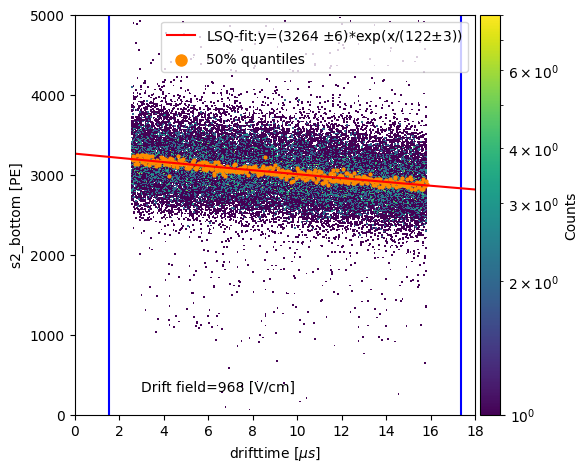

In [15]:
y=np.array(ak.flatten(events.s2.area_pe_bot))
x=np.array(events.drifttime_musec) 
y_max_plot=5000
w, h = mtpl.figure.figaspect(0.94)
fig = plt.figure(figsize=(w, h), dpi=100)
axes = fig.add_axes([1,1,1,1])
h,xedges,yedges,img1 = axes.hist2d(x,y,range=[[0,drifttime_drawing_limit],[0,y_max_plot]],
                            norm=LogNorm(),bins=(500,500))
plt.xlabel('drifttime [$\mu s$]')
plt.ylabel('s2_bottom [PE]')
p=colorbar(img1)
p.set_label(r'Counts', rotation=90) 

quantiles = []
bin_center=[]
for i in range(len(xedges)-1):
    y_data = y[(x<xedges[i+1])&(x>xedges[i])]
    if len(y_data) != 0:
        quantiles.append(np.quantile(y_data,.50))
        bin_center.append((xedges[i]+xedges[i+1])/2)


#Fit the quantiles
from scipy.odr import ODR, Model, Data, RealData

def func(beta, x):
    return beta[0]*np.exp(-x/beta[1])



x=np.array(bin_center)
y=np.array(quantiles) 
y = y[(x<cathode_time)&(x>gate_time)]
x = x[(x<cathode_time)&(x>gate_time)]

data = RealData(x, y)
model = Model(func)

odr = ODR(data, model, beta0=[4000,124])  #ODR collapses to Least Square if no x-error present, beta0= intial guess
odr.set_job(fit_type=2)                 #fit_type=2 corresponds to LSQ and fit_type=0 to ODR
output = odr.run()


xn = np.linspace(0,drifttime_drawing_limit,200)
yn = func(output.beta, xn)

a,b = output.beta 
a_error, b_error = output.sd_beta

axes.scatter(bin_center,quantiles,s=4,marker="o",c='darkorange', label="50% quantiles")
#axes.scatter(x,y,s=4,marker="o",c='black', label="50% quantiles")
axes.plot(xn, yn , 'r-', label=r'LSQ-fit:y=({:.0f} $\pm${:.0f})*exp(x/({:.0f}$\pm${:.0f}))'.format(a,a_error,b,b_error))
axes.legend(loc="upper right",frameon=True,markerscale=4.)
axes.text(3,300,text)
axes.vlines(gate_time,0,y_max_plot,colors="blue")
axes.vlines(cathode_time,0,y_max_plot,colors="blue")
#plt.savefig("plots/"+name+"s2_bottom_correction.png", bbox_inches = "tight")
plt.show()

Apply the correction

In [16]:
y=np.array(ak.flatten(events.s2.area_pe_bot))
x=np.array(events.drifttime_musec)

events["cs2_area_pe_bot"] = ak.singletons(a*(y)/(a*np.exp(-x/b)))

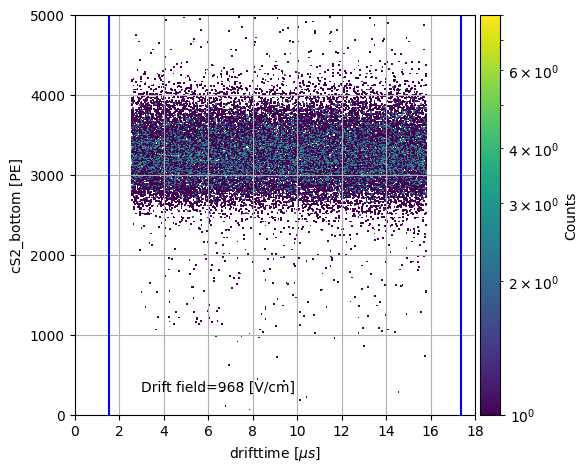

In [17]:
y = np.array(events.cs2_area_pe_bot)
w, h = mtpl.figure.figaspect(0.94)
fig = plt.figure(figsize=(w, h), dpi=100)
axes = fig.add_axes([1,1,1,1])
h,xedges,yedges,img1 = axes.hist2d(x,y,range=[[0,drifttime_drawing_limit],[0,5000]],norm=LogNorm(),bins=(500,500) )
plt.xlabel('drifttime [$\mu s$]')
plt.ylabel('cS2_bottom [PE]')
plt.grid()
axes.vlines(gate_time,0,5000,colors="blue")
axes.vlines(cathode_time,0,5000,colors="blue")
axes.text(3,300,text)
p=colorbar(img1)
p.set_label(r'Counts', rotation=90) 
#plt.savefig("plots/"+name+"s2_bottom_corrected.png", bbox_inches = "tight")
plt.show()

# S2 Top  

$ cS2_\text{top} = S2_\text{top} * \text{exp}(\text{driftime}/\text{lifetime}) $   

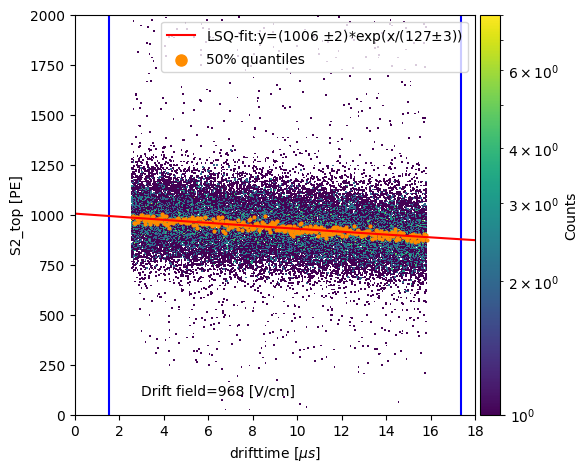

In [18]:
y=np.array(ak.flatten(events.s2.area_pe_top))
x=np.array(events.drifttime_musec)

y_max_plot = 2000
w, h = mtpl.figure.figaspect(0.94)
fig = plt.figure(figsize=(w, h), dpi=100)
axes = fig.add_axes([1,1,1,1])
h,xedges,yedges,img1 = axes.hist2d(x,y ,range=[[0,drifttime_drawing_limit],[0,y_max_plot]],  norm=LogNorm(),bins=(500,500) )
plt.xlabel('drifttime [$\mu s$]')
plt.ylabel('S2_top [PE]')
p=colorbar(img1)
p.set_label(r'Counts', rotation=90) 

quantiles = []
bin_center=[]
for i in range(len(xedges)-1):
    y_data = y[(x<xedges[i+1])&(x>xedges[i])]
    if len(y_data) != 0:
        quantiles.append(np.quantile(y_data,.50))
        bin_center.append((xedges[i]+xedges[i+1])/2)


#Fit the quantiles
from scipy.odr import ODR, Model, Data, RealData

def func(beta, x):
    return beta[0]*np.exp(-x/beta[1])



x=np.array(bin_center)
y=np.array(quantiles) 
y = y[(x<cathode_time)&(x>gate_time)]
x = x[(x<cathode_time)&(x>gate_time)]

data = RealData(x, y)
model = Model(func)

odr = ODR(data, model, beta0=[4000,124])  #ODR collapses to Least Square if no x-error present, beta0= intial guess
odr.set_job(fit_type=2)                 #fit_type=2 corresponds to LSQ and fit_type=0 to ODR
output = odr.run()


xn = np.linspace(0,drifttime_drawing_limit,200)
yn = func(output.beta, xn)

a,b = output.beta 
a_error, b_error = output.sd_beta

axes.scatter(bin_center,quantiles,s=4,marker="o",c='darkorange', label="50% quantiles")
#axes.scatter(x,y,s=4,marker="o",c='black', label="50% quantiles")
axes.plot(xn, yn , 'r-', label=r'LSQ-fit:y=({:.0f} $\pm${:.0f})*exp(x/({:.0f}$\pm${:.0f}))'.format(a,a_error,b,b_error))
axes.legend(loc="upper right",frameon=True,markerscale=4.)
axes.text(3,100,text)
axes.vlines(gate_time,0,y_max_plot,colors="blue")
axes.vlines(cathode_time,0,y_max_plot,colors="blue")
#plt.savefig("plots/"+name+"s2_top_correction.png", bbox_inches = "tight")
plt.show()

In [19]:
y=np.array(ak.flatten(events.s2.area_pe_top))
x=np.array(events.drifttime_musec)

events["cs2_area_pe_top"] = ak.singletons(a*(y)/(a*np.exp(-x/b)))

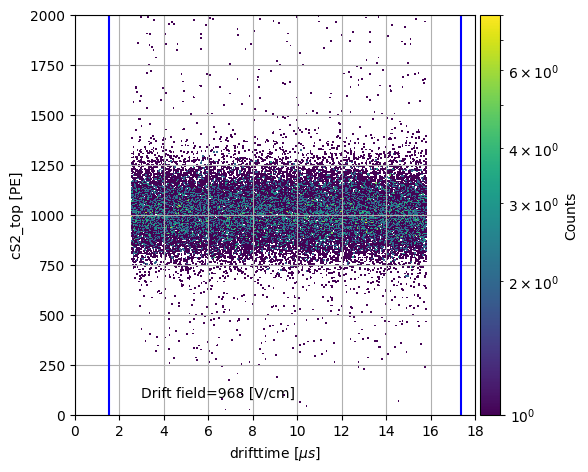

In [20]:
y = np.array(events.cs2_area_pe_top)

w, h = mtpl.figure.figaspect(0.94)
fig = plt.figure(figsize=(w, h), dpi=100)
axes = fig.add_axes([1,1,1,1])
h,xedges,yedges,img1 = axes.hist2d(x,y ,range=[[0,drifttime_drawing_limit],[0,y_max_plot]],norm=LogNorm(),  bins=(500,500) )
plt.xlabel('drifttime [$\mu s$]')
plt.ylabel('cS2_top [PE]')
plt.grid()
p=colorbar(img1)
p.set_label(r'Counts', rotation=90) 
axes.vlines(gate_time,0,y_max_plot,colors="blue")
axes.vlines(cathode_time,0,y_max_plot,colors="blue")
axes.text(3,90,text)
#plt.savefig("plots/"+name+"s2_top_corrected.png", bbox_inches = "tight")

plt.show()

# S1 Correction 

**S1 Bottom**

$S1 = a0 + a1*t + a2*t^2 + a3*t^3 + a4*t^4$

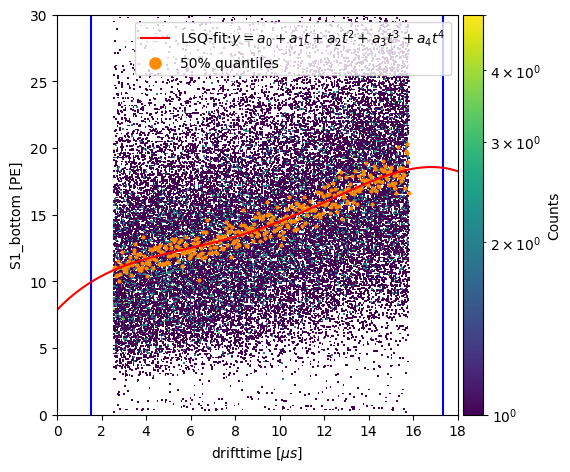

In [21]:
y=np.array(ak.flatten(events.s1.area_pe_bot[events["mask_max_s1_before_s2"]]))
x=np.array(events.drifttime_musec) 

y_max_plot = 30
w, h = mtpl.figure.figaspect(0.94)
fig = plt.figure(figsize=(w, h), dpi=100)
axes = fig.add_axes([1,1,1,1])
h,xedges,yedges,img1 = axes.hist2d(x,y,range=[[0,drifttime_drawing_limit],[0,y_max_plot]],
                                   bins=(500,500),norm=LogNorm())#
plt.xlabel('drifttime [$\mu s$]')
plt.ylabel('S1_bottom [PE]')
p=colorbar(img1)
p.set_label(r'Counts', rotation=90) 

quantiles = []
bin_center=[]
for i in range(len(xedges)-1):
    y_data = y[(x<xedges[i+1])&(x>xedges[i])]
    if len(y_data) != 0:
        quantiles.append(np.quantile(y_data,.50))
        bin_center.append((xedges[i]+xedges[i+1])/2)

x=np.array(bin_center)
y=np.array(quantiles) 
y = y[(x<cathode_time)&(x>gate_time)]
x = x[(x<cathode_time)&(x>gate_time)]

def func(beta, x):
    return beta[0]+beta[1]*x+beta[2]*x**2+beta[3]*x**3+beta[4]*x**4

data = RealData(x, y)
model = Model(func)

odr = ODR(data, model, beta0=[210,14,-1.72,0.16,-0.0046])  #ODR collapses to Least Square if no x-error present, beta0= intial guess
odr.set_job(fit_type=2)                 #fit_type=2 corresponds to LSQ and fit_type=0 to ODR
output = odr.run()


xn = np.linspace(0,drifttime_drawing_limit,200)
yn = func(output.beta, xn)

a0,a1,a2,a3,a4 = output.beta 
a0_error,a1_error,a2_error,a3_error,a4_error = output.sd_beta


#axes.scatter(x,y,s=4,marker="o",c='black', label="50% quantiles")
axes.scatter(bin_center,quantiles,s=4,marker="o",c='darkorange', label="50% quantiles")
#axes.plot(xn, yn , 'r-', label=r'LSQ-fit:y={:.1f}+{:.1f}*t+{:.1f}*10^-2*t^2+{:.1f}*10^-3*t^3 + {:.1f}*10^-4*t^4 '.format(a0,a1,a2*10**2,a3*10**3,a4*10**4))
axes.plot(xn, yn , 'r-', label=r'LSQ-fit:$y=a_{0}+a_{1}t+a_{2}t^2+a_{3}t^3+a_{4}t^4$')

axes.legend(loc="upper right",frameon=True,markerscale=4.)
axes.vlines(gate_time,0,y_max_plot,colors="blue")
axes.vlines(cathode_time,0,y_max_plot,colors="blue")
#plt.savefig("plots/"+name+"s1_bottom_correction.png", bbox_inches = "tight")
plt.show()

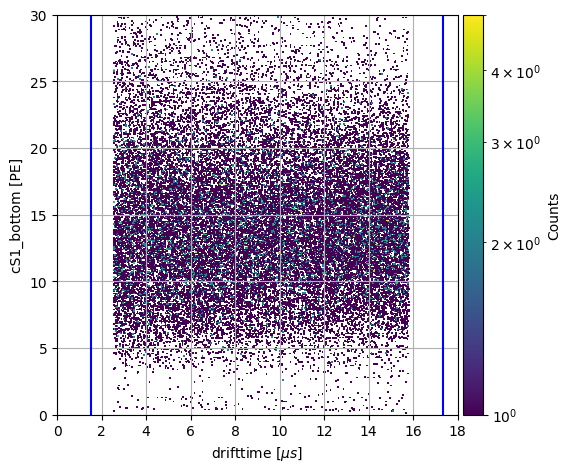

In [22]:
y=np.array(ak.flatten(events.s1.area_pe_bot[events["mask_max_s1_before_s2"]]))
x=np.array(events.drifttime_musec)

A = func(output.beta, (gate_time+cathode_time)/2)
events["cs1_area_pe_bot"] = A*(y)/(func(output.beta,x))


w, h = mtpl.figure.figaspect(0.94)
fig = plt.figure(figsize=(w, h), dpi=100)
axes = fig.add_axes([1,1,1,1])
h,xedges,yedges,img1 = axes.hist2d(x,np.array(events["cs1_area_pe_bot"]) ,range=[[0,drifttime_drawing_limit],[0,y_max_plot]],
                                   norm=LogNorm(),bins=(500,500) )
plt.xlabel('drifttime [$\mu s$]')
plt.ylabel('cS1_bottom [PE]')
plt.grid()
p=colorbar(img1)
p.set_label(r'Counts', rotation=90) 
axes.vlines(gate_time,0,y_max_plot,colors="blue")
axes.vlines(cathode_time,0,y_max_plot,colors="blue")
#plt.savefig("plots/"+name+"s1_bottom_corrected.png", bbox_inches = "tight")

plt.show()

**S1 Top** 

$cS1_{top} = a*S1_{top}+b $ <br />

and a & b found from fitting gaussian peaks. 

In [23]:
events.s1.area_pe_top[events["mask_max_s1_before_s2"]]

<Array [[0.73], [0.888], ... [2.52], [1.59]] type='36650 * option[var * ?float64]'>

In [24]:
y=np.array(ak.flatten(events.s1.area_pe_top[events["mask_max_s1_before_s2"]]))
x=np.array(events.drifttime_musec)

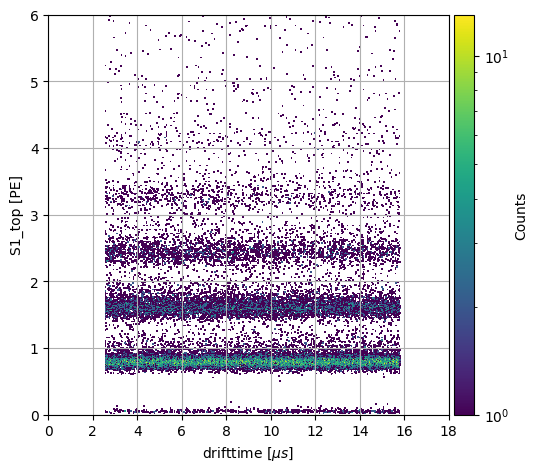

In [25]:
y_max_plot = 6
w, h = mtpl.figure.figaspect(0.94)
fig = plt.figure(figsize=(w, h), dpi=100)
axes = fig.add_axes([1,1,1,1])
h,xedges,yedges,img1 = axes.hist2d(x,y ,range=[[0,drifttime_drawing_limit],[0,y_max_plot]],
                                   norm=LogNorm(),bins=(500,500))
plt.xlabel('drifttime [$\mu s$]')
plt.ylabel('S1_top [PE]')
plt.grid()
p=colorbar(img1)
p.set_label(r'Counts', rotation=90) 
#plt.savefig("plots/"+name+"s1_top_correction1.png", bbox_inches = "tight")

plt.show()

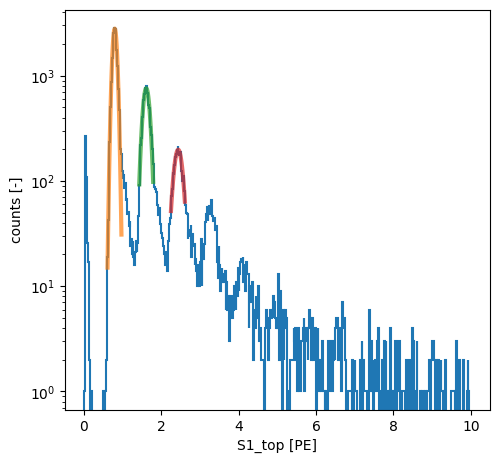

In [26]:
from scipy.signal import find_peaks
from scipy.optimize import curve_fit

w, h = mtpl.figure.figaspect(0.94)
fig = plt.figure(figsize=(w, h), dpi=100)
#fig = plt.figure(figsize=(12, 6), dpi=100)
axes = fig.add_axes([1,1,1,1])
h,xedges,img1 = axes.hist(y ,range=[0,10],bins=500,histtype=u'step', linewidth=1.5)


peaks, _ = find_peaks(h, threshold=2,distance=20,width=3, height=100)


upper_indices = peaks+9
lower_indices = peaks-9
bin_width= xedges[1]-xedges[0]

def func(x, a, b, c):
    return a * np.exp(-0.5*((x-b)/c)**2)

mu = []
sigma = []
n_events = []

for i,j,n in zip(lower_indices,upper_indices,range(len(peaks))):
    xdata    = xedges[i:j]+bin_width/2
    ydata    = h[i:j]
    n_events.append(np.sum(h[i:j]))
    init  = [h[peaks[n]], xedges[peaks[n]], 0.5]
    popt, pcov = curve_fit(func, xdata, ydata,p0=init)
    x_plot = np.linspace(xedges[i]+bin_width/2, xedges[j]+bin_width/2, 30)
    mu.append(popt[1])
    sigma.append(popt[2])
    axes.plot(x_plot, func(x_plot, *popt), linewidth=3, alpha =0.7)
    
    
#plt.vlines(xedges[lower_indices],0,10000, linestyle="dotted",linewidth=0.5)
#plt.vlines(xedges[upper_indices],0,10000, linestyle="dotted",linewidth=0.5)
#plt.yscale('log')
#plt.vlines(xedges[peaks],0,10000)
plt.yscale("log")
plt.xlabel('S1_top [PE]')
plt.ylabel('counts [-]')
#plt.ylim(5,1.2*max(h[peaks]))
#plt.savefig("plots/"+name+"s1_top_correction2.png", bbox_inches = "tight")
plt.show()

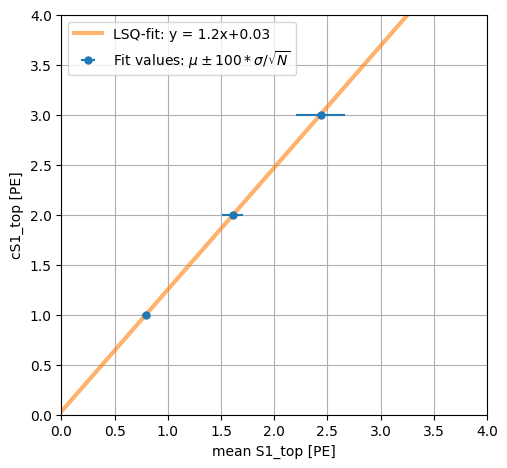

In [27]:
def f(x,a,b):
    return a*x+b

xdata= mu
ydata= range(1,len(peaks)+1)
init  = [1, 0]
popt, pcov = curve_fit(f, xdata, ydata,p0=init)
x_plot = np.linspace(0, len(peaks)+1, 100)
w, h = mtpl.figure.figaspect(0.94)
fig = plt.figure(figsize=(w, h), dpi=100)
axes = fig.add_axes([1,1,1,1])
axes.errorbar(xdata,ydata, xerr=100*np.array(sigma)/np.sqrt(np.array(n_events)),marker='.',linestyle ="",
              markersize=10, label=r"Fit values: $\mu \pm 100*\sigma/\sqrt{N}$" )
plt.plot(x_plot, f(x_plot, *popt), linewidth=3, alpha =0.6, label="LSQ-fit: y = {:.1f}x+{:.2f}".format(popt[0],popt[1]))
plt.xlabel('mean S1_top [PE]')
plt.ylabel('cS1_top [PE]')
plt.xlim(0,len(mu)+1)
plt.ylim(0,len(mu)+1)
plt.legend(loc="best")
plt.grid()
#plt.savefig("plots/"+name+"s1_top_correction3.png", bbox_inches = "tight")
plt.show()

Apply the correction

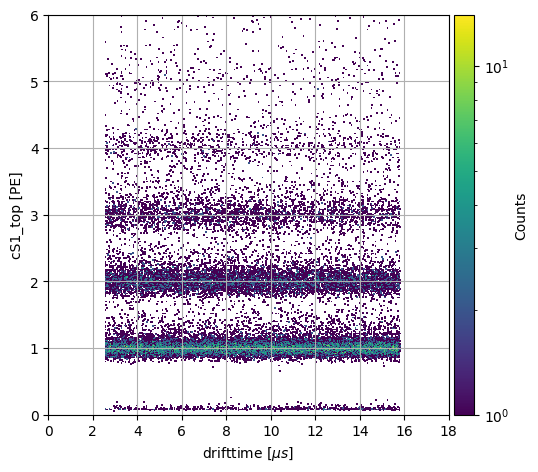

In [28]:
events["cs1_area_pe_top"] = y*popt[0]+popt[1]


x = np.array(events.drifttime_musec) 
y = np.array(events["cs1_area_pe_top"])


w, h = mtpl.figure.figaspect(0.94)
fig = plt.figure(figsize=(w, h), dpi=100)
axes = fig.add_axes([1,1,1,1])
h,xedges,yedges,img1 = axes.hist2d(x,y,range=[[0,drifttime_drawing_limit],[0,y_max_plot]],  norm=LogNorm(),bins=(500,500) )
plt.xlabel('drifttime [$\mu s$]')
plt.ylabel('cS1_top [PE]')
plt.grid()
p=colorbar(img1)
p.set_label(r'Counts', rotation=90)
#plt.savefig("plots/"+name+"s1_top_corrected.png", bbox_inches = "tight")
plt.show()

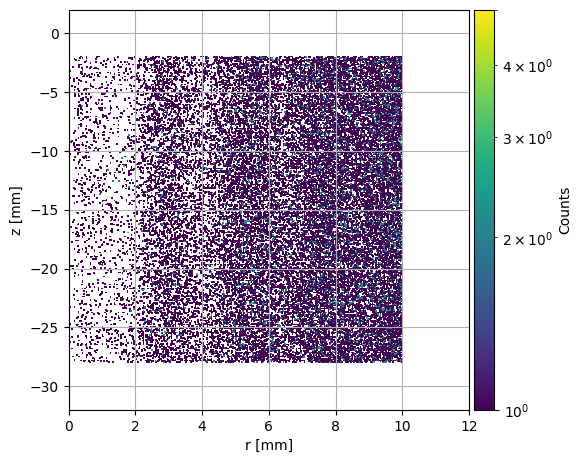

In [29]:
w, h = mtpl.figure.figaspect(0.94)
fig = plt.figure(figsize=(w, h), dpi=100)
axes = fig.add_axes([1,1,1,1])
h,xedges,yedges,img1 = axes.hist2d(np.array(events["r_s2"]),np.array(events["z"]),
                                   range=[[0,12],[-32,2]],  norm=LogNorm(),bins=(500,500) )
plt.xlabel('r [mm]')
plt.ylabel('z [mm]')
plt.grid()
p=colorbar(img1)
p.set_label(r'Counts', rotation=90) 
#plt.savefig("plots/"+name+"fiducialized.png", bbox_inches = "tight")
plt.show()

# Yields

# S2_total/S1_total	

In [30]:
events["cs1"] = events["cs1_area_pe_top"]+events["cs1_area_pe_bot"] 
events["cs2"] = events["cs2_area_pe_top"]+events["cs2_area_pe_bot"] 


def statistics(xdata,ydata):
    vxy = np.cov(xdata,ydata)
    mu_x=np.mean(xdata)
    mu_y=np.mean(ydata)
    
    sigma_x = np.sqrt(vxy[0][0])
    sigma_y = np.sqrt(vxy[1][1])
    rho = vxy[0][1]/(sigma_x*sigma_y)
    
    return  [vxy,mu_x,mu_y,sigma_x,sigma_y,rho]

#print(statistics(df["cS1"],df["cS2"])[2])
def ellipse_density(stats,x_coordinate=None,y_coordinate=None,k=None):
    vxy=stats[0]
    mu_x=stats[1]
    mu_y=stats[2]
    sigma_x = stats[3]
    sigma_y = stats[4]
    rho = stats[5]
    
    if x_coordinate is not None and y_coordinate is not None:
        return 1/(2*np.pi*np.sqrt(np.linalg.det(vxy)))*np.exp(-0.5*1/(1-rho**2)*((x_coordinate-mu_x)**2/sigma_x**2 -2*rho*(x_coordinate-mu_x)*(y_coordinate-mu_y)/(sigma_x*sigma_y)+(y_coordinate-mu_y)**2/sigma_y**2))
    else: 
        return 1/(2*np.pi*np.sqrt(np.linalg.det(vxy)))*np.exp(-0.5*1/(1-rho**2)*(k**2))

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:42: UserWarning: The following kwargs were not used by contour: 'label'


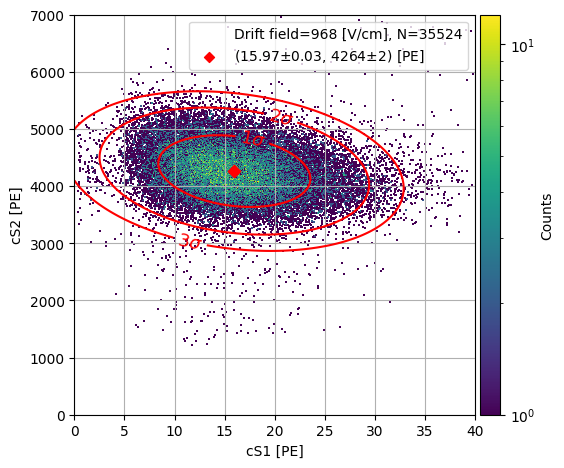

In [31]:
import matplotlib.cm as cm

x_lim_low = 0
x_lim_high = 40


y_lim_low = 0
y_lim_high = 7000

x = np.linspace(x_lim_low, x_lim_high, 500)
y = np.linspace(y_lim_low, y_lim_high, 500)
X, Y = np.meshgrid(x, y)

#Important to restrict the statistics to the window of view!
events_plot = events[(events["cs1"]<x_lim_high)& (events["cs2"]<y_lim_high)]
stats =statistics(np.array(events_plot["cs1"]),np.array(events_plot["cs2"]))
Z= ellipse_density(stats,X,Y)
    
#Find the sigma lines
percent_within_sigma=[ 0.9973, 0.9545,0.6827 ]
range_of_k = np.linspace(0,3,50) 
events_within_percent = []


for i in range_of_k:
    events_within_percent.append(len(events_plot[np.array(ellipse_density(stats,np.array(events_plot["cs1"]),np.array(events_plot["cs2"])))
                                             >ellipse_density(stats,k=i)])
                                 /len(events_plot["cs1"]))

k_at_sigma = [np.max(range_of_k[np.array(events_within_percent) < i]) for i in percent_within_sigma]
levels = [ellipse_density(stats,k=i) for i in k_at_sigma]
n = len(events_plot[np.array(ellipse_density(stats,np.array(events_plot["cs1"]),
                                             np.array(events_plot["cs2"]))>ellipse_density(stats,k=k_at_sigma[0]))]) 


w, h = mtpl.figure.figaspect(0.94)
fig = plt.figure(figsize=(w, h), dpi=100)
axes = fig.add_axes([1,1,1,1])
h,xedges,yedges,img1 = axes.hist2d(np.array(events_plot["cs1"]),np.array(events_plot["cs2"])
                                   ,bins=(400,400),range=[[x_lim_low,x_lim_high],[y_lim_low,y_lim_high]],norm=LogNorm()) 

CS = axes.contour(X, Y, Z, levels=levels, label="1,2,3 $\sigma$",colors="red")
fmt = {}
strs = [r'$3\sigma$', r'$2\sigma$', r'$1\sigma$' ]
for l, s in zip(CS.levels, strs):
    fmt[l] = s

axes.clabel(CS,CS.levels,fmt=fmt , inline=1, fontsize=13,colors="red")
axes.scatter(stats[1],stats[2],color="red",marker="D",s=40,
             label=r"({:.2f}$\pm${:.2f}, {:.0f}$\pm${:.0f}) [PE]".format(stats[1],stats[3]/np.sqrt(n), stats[2],stats[4]/np.sqrt(n)))
axes.plot([], [], ' ', label=text+", N="+str(len(events_plot)))
plt.xlabel('cS1 [PE]')
plt.ylabel('cS2 [PE]')
plt.legend(loc="best",markerscale=0.8)
plt.grid()
p=colorbar(img1)
p.set_label(r'Counts', rotation=90) 
#plt.savefig("plots/"+name+"s2_total_vs_s1_total.png", bbox_inches = "tight")
plt.show()

# S2_b/S1_total

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:40: UserWarning: The following kwargs were not used by contour: 'label'


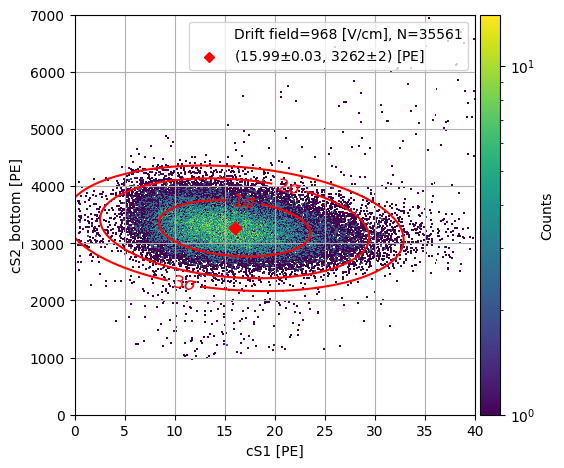

In [32]:
x_lim_low = 0
x_lim_high = 40

y_lim_low = 0
y_lim_high = 7000

x = np.linspace(x_lim_low, x_lim_high, 500)
y = np.linspace(y_lim_low, y_lim_high, 500)
X, Y = np.meshgrid(x, y)


#Important to restrict the statistics to the window of view!
events_plot = events[(events["cs1"]<x_lim_high)& (events["cs2_area_pe_bot"]<y_lim_high)]
stats =statistics(np.array(events_plot["cs1"]),np.array(events_plot["cs2_area_pe_bot"]))
Z= ellipse_density(stats,X,Y)

#Find the sigma lines
percent_within_sigma=[ 0.9973, 0.9545,0.6827 ]
range_of_k = np.linspace(0,3,50) 
events_within_percent = []


for i in range_of_k:
    events_within_percent.append(len(events_plot[np.array(ellipse_density(stats,np.array(events_plot["cs1"]),
                          np.array(events_plot["cs2_area_pe_bot"])))>ellipse_density(stats,k=i)])
                          /len(events_plot["cs1"]))

k_at_sigma = [np.max(range_of_k[np.array(events_within_percent) < i]) for i in percent_within_sigma]
levels = [ellipse_density(stats,k=i) for i in k_at_sigma]
n = len(events_plot[np.array(ellipse_density(stats,np.array(events_plot["cs1"]),np.array(events_plot["cs2_area_pe_bot"]))
                             >ellipse_density(stats,k=k_at_sigma[0]))]) 


w, h = mtpl.figure.figaspect(0.94)
fig = plt.figure(figsize=(w, h), dpi=100)
axes = fig.add_axes([1,1,1,1])
h,xedges,yedges,img1 = axes.hist2d(np.array(events_plot["cs1"]),np.array(events_plot["cs2_area_pe_bot"])
                                   ,bins=(400,400),range=[[x_lim_low,x_lim_high],[y_lim_low,y_lim_high]],norm=LogNorm()) 

CS = axes.contour(X, Y, Z, levels=levels, label="1,2,3 $\sigma$",colors="red")
fmt = {}
strs = [r'$3\sigma$', r'$2\sigma$', r'$1\sigma$' ]
for l, s in zip(CS.levels, strs):
    fmt[l] = s

axes.clabel(CS,CS.levels,fmt=fmt , inline=1, fontsize=13,colors="red")
axes.scatter(stats[1],stats[2],color="red",marker="D",s=40,
             label=r"({:.2f}$\pm${:.2f}, {:.0f}$\pm${:.0f}) [PE]".format(stats[1],stats[3]/np.sqrt(n),stats[2],stats[4]/np.sqrt(n)))
axes.plot([], [], ' ', label=text+", N="+str(len(events_plot)))
plt.xlabel('cS1 [PE]')
plt.ylabel('cS2_bottom [PE]')
plt.legend(loc="best",markerscale=0.8)
plt.grid()
p=colorbar(img1)
p.set_label(r'Counts', rotation=90,) 
#plt.savefig("plots/"+name+"s2_bottom_vs_s1_total.png", bbox_inches = "tight")
plt.show()

# S2_t/S1_total

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:39: UserWarning: The following kwargs were not used by contour: 'label'


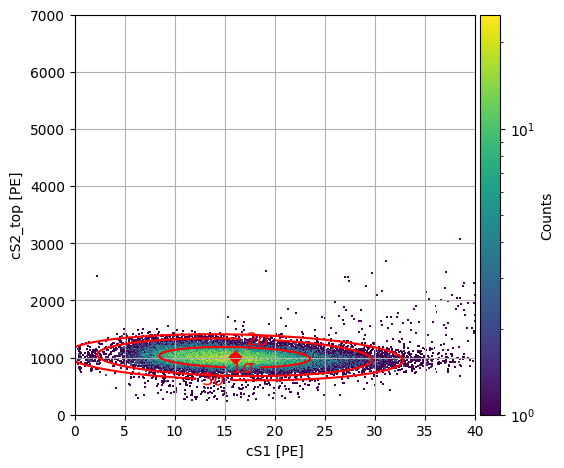

In [33]:
x_lim_low = 0
x_lim_high = 40

y_lim_low = 0
y_lim_high = 7000

x = np.linspace(x_lim_low, x_lim_high, 500)
y = np.linspace(y_lim_low, y_lim_high, 500)
X, Y = np.meshgrid(x, y)

#Important to restrict the statistics to the window of view!
events_plot = events[(events["cs1"]<x_lim_high)& (events["cs2_area_pe_top"]<y_lim_high)]
stats =statistics(np.array(events_plot["cs1"]),np.array(events_plot["cs2_area_pe_top"]))
Z= ellipse_density(stats,X,Y)
    
#Find the sigma lines
percent_within_sigma=[ 0.9973, 0.9545,0.6827 ]
range_of_k = np.linspace(0,3,50) 
events_within_percent = []


for i in range_of_k:
    events_within_percent.append(len(events_plot[np.array(ellipse_density(stats,np.array(events_plot["cs1"]),
                          np.array(events_plot["cs2_area_pe_top"])))>ellipse_density(stats,k=i)])
                          /len(events_plot["cs1"]))

k_at_sigma = [np.max(range_of_k[np.array(events_within_percent) < i]) for i in percent_within_sigma]
levels = [ellipse_density(stats,k=i) for i in k_at_sigma]
n = len(events_plot[np.array(ellipse_density(stats,np.array(events_plot["cs1"]),np.array(events_plot["cs2_area_pe_top"]))
                             >ellipse_density(stats,k=k_at_sigma[0]))]) 


w, h = mtpl.figure.figaspect(0.94)
fig = plt.figure(figsize=(w, h), dpi=100)
axes = fig.add_axes([1,1,1,1])
h,xedges,yedges,img1 = axes.hist2d(np.array(events_plot["cs1"]),np.array(events_plot["cs2_area_pe_top"])
                                   ,bins=(400,400),range=[[x_lim_low,x_lim_high],[y_lim_low,y_lim_high]],norm=LogNorm()) 

CS = axes.contour(X, Y, Z, levels=levels, label="1,2,3 $\sigma$",colors="red")
fmt = {}
strs = [r'$3\sigma$', r'$2\sigma$', r'$1\sigma$' ]
for l, s in zip(CS.levels, strs):
    fmt[l] = s

axes.clabel(CS,CS.levels,fmt=fmt , inline=1, fontsize=13,colors="red")
axes.scatter(stats[1],stats[2],color="red",marker="D",s=40,
             label=r"({:.2f}$\pm${:.2f}, {:.0f}$\pm${:.0f}) [PE]".format(stats[1],stats[3]/np.sqrt(n),stats[2],stats[4]/np.sqrt(n)))
axes.plot([], [], ' ', label=text+", N="+str(len(events_plot)))
plt.xlabel('cS1 [PE]')
plt.ylabel('cS2_top [PE]')
plt.grid()
p=colorbar(img1)
p.set_label(r'Counts', rotation=90) 
#plt.savefig("plots/"+name+"s2_top_vs_s1_total.png", bbox_inches = "tight")
plt.show()

In [34]:
import ROOT
from IPython.display import Image

cs1_low=0
cs1_high=40
cs2_low=0
cs2_high=7000

h1 = ROOT.TH2F("h1","Fit to Ar37 2.82 keV",100,cs1_low,cs1_high,100,cs2_low,cs2_high)

#Important to restrict the statistics to the window of view!
events_plot = events[(events["cs1"]<x_lim_high)& (events["cs2"]<y_lim_high)]

for i in range(len(events_plot)):
    h1.Fill(events_plot["cs1"][i],events_plot["cs2"][i])

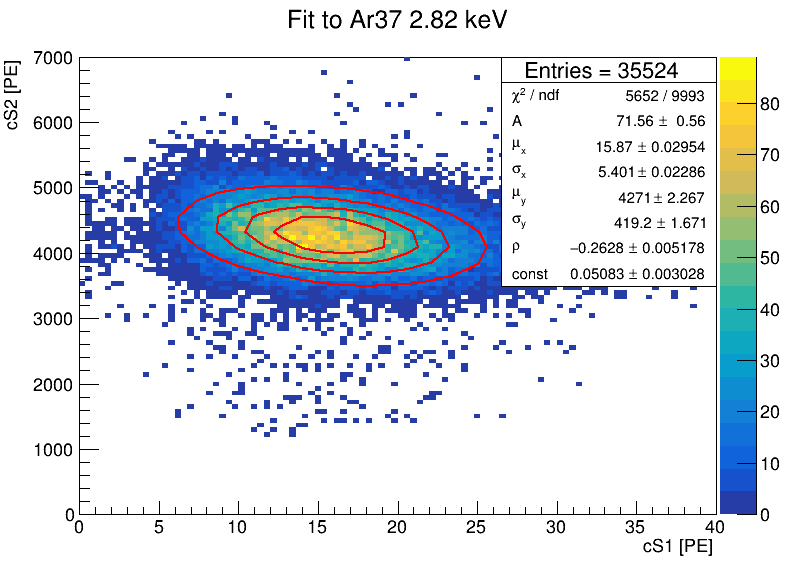

 FCN=3530.23 FROM MINOS     STATUS=SUCCESSFUL    104 CALLS        1620 TOTAL
                     EDM=3.13474e-07    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  A            7.15570e+01   5.60008e-01   1.28846e-03  -4.59750e-07
   2  #mu_{x}      1.58726e+01   2.95379e-02  -2.99321e-05  -9.09998e-06
   3  #sigma_{x}   5.40093e+00   2.28579e-02  -7.39259e-05   1.61613e-05
   4  #mu_{y}      4.27089e+03   2.26733e+00   2.37973e-04   8.18050e-08
   5  #sigma_{y}   4.19153e+02   1.67129e+00  -4.25309e-03  -1.00687e-07
   6  #rho        -2.62773e-01   5.17779e-03  -4.21816e-06   1.07935e-04
   7  const        5.08291e-02   3.02817e-03   3.02817e-03  -3.11193e-03
                               ERR DEF= 0.5


Info in <TCanvas::Print>: png file s2_bottom_vs_s1_total_rootfit.png has been created


In [35]:
# theta,mux,sigmax,muy,sigmay,A,const + theta2,mux2,sigmax2,muy2,sigmay2,A2
g = ROOT.TF2("g","[6]+[5]*exp(-0.5*((((cos([0])*(x-[1])-sin([0])*(y-[3]))/[2])**2)+((sin([0])*(x-[1])+cos([0])*(y-[3]))/[4])**2))",cs1_low,cs1_high,cs2_low,cs2_high)
f = ROOT.TF2("f", "[6]+[0]*exp(-0.5*(1/(1-[5]**2))*(((x-[1])/[2])**2+((y-[3])/[4])**2-2*[5]*(x-[1])*(y-[3])/([2]*[4])))",cs1_low,cs1_high,cs2_low,cs2_high)

g.SetParameter(0,0.6)                   #theta
g.SetParLimits(0,0,3.14)
g.SetParameter(1,-40)                      #mux
g.SetParameter(2,6)                        #sigmax
g.SetParameter(3,4000)                       #muy
g.SetParameter(4,300)                     #sigmay
g.SetParameter(5,800)                      #A                  
g.SetParameter(6,10)                    #constant
        
f.SetParameter(0,20)                   #A
f.SetParameter(1,15)                      #mux
f.SetParameter(2,6)                        #sigmax
f.SetParameter(3,4000)                       #muy
f.SetParameter(4,100)                     #sigmay
f.SetParameter(5,-0.4)                      #rho                  
f.SetParameter(6,10)                    #constant
    

f.SetParName(0, "A")
f.SetParName(1, "#mu_{x}")
f.SetParName(2, "#sigma_{x}")
f.SetParName(3, "#mu_{y}")
f.SetParName(4, "#sigma_{y}")
f.SetParName(5, "#rho")
f.SetParName(6, "const")

f.SetContour(5,)

c = ROOT.TCanvas("myCanvasName","The Canvas Title",800,600)
fit = h1.Fit("f", "SELRM") #L for Likelihood,E better erro, R for only fitting in range, 
#fit = h1.Fit("g", "SELRM") #L for Likelihood,E better erro, R for only fitting in range, 


ROOT.gStyle.SetOptFit(111)
ROOT.gStyle.SetOptStat("e")
ROOT.gStyle.SetFitFormat('3.1f')
ROOT.gStyle.SetStatFormat('3.1f')
ROOT.gStyle.SetPalette(57)

h1.Draw('colz')
h1.GetXaxis().SetTitle('cS1 [PE]')
h1.GetYaxis().SetTitle('cS2 [PE]')
h1.GetYaxis().SetTitleOffset(1.5)
#g.Draw('cont1 same')
#f.Draw('cont1 same')
c.cd()

# Legend
ROOT.gPad.Update()
st = h1.FindObject("stats")
st.SetX1NDC(0.63) #//new x start position
st.SetX2NDC(0.9)  #//new x end position
st.SetY1NDC(0.5)
st.SetY2NDC(0.9)

c.Update()
c.SaveAs("s2_bottom_vs_s1_total_rootfit.png")
Image(filename="s2_bottom_vs_s1_total_rootfit.png")